<a href="https://colab.research.google.com/github/aaronhallaert/DeepLearningLab/blob/main/Final_Project/Deep_Learning_Final_Project_Artist_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artist Recognition


## Initialization

### Imports and Drive Management

In [2]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os
import re
import pickle

# fix random seed for reproducibility
seed = 2021
np.random.seed(seed)  

from sklearn.model_selection import train_test_split
from pathlib import Path

!pip install tf-keras-vis
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks.experimental import BackupAndRestore

2.4.1


In [3]:
# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')


#!ls '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#helper functions for visualisation

# same function as before - feel free to customize if you want!

def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

### Load data

Dataset already present in local environment
Loading the predefined splits


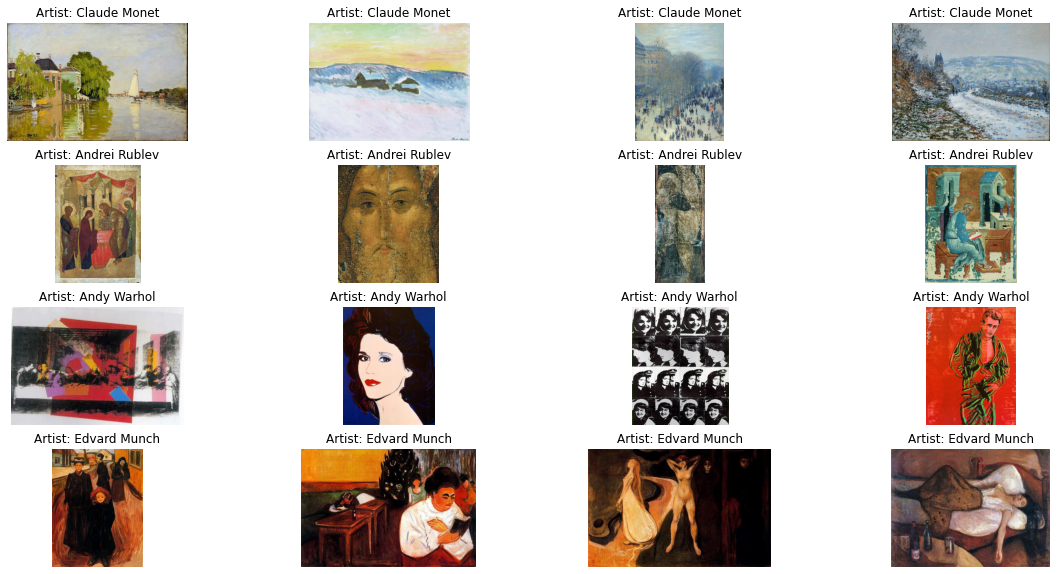

In [5]:
# resized/firstname_lastname_#.jpg
# images/firstname_lastname/firstname_lastname_#.jpg
import random

# path to google drive zip
path_to_zip = '/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/artists_recognition_dataset.zip'
# local path to data zip
local_path_to_folder = '/content/artists_recognition_dataset'

# download zip if it does not yet exist in local environment
if not Path(local_path_to_folder.replace(".zip", "")).exists():
  print("Downloading dataset to local environment...")
  !rsync --info=progress2 "{path_to_zip}" .
  print("Extracting dataset in local environment...")
  !unzip -q artists_recognition_dataset.zip | awk 'BEGIN {ORS=" "} {if(NR%10==0)print "."}'
  print("Removing zip to save space...")
  !rm artists_recognition_dataset.zip
else:
  print("Dataset already present in local environment")


# path to folder with images
path = '/content/artists_recognition_dataset/resized/resized'
images_dir = Path(path)

### PARSE DATASET ###

# key = path_to_image:Path
# value = artist:str
painting_artist_dict = {}

# key = artist:str
# value = path_to_image:Path
artist_painting_dict = {}

for image in images_dir.rglob("*"):
  if image.is_file() and str(image).endswith("jpg"):
        # Extract label from filename
        pattern= re.compile(r"(.*)_(\d*).jpg$")
        match = pattern.match(str(image.name))
        artist = match.group(1)
        instance = match.group(2)

        painting_artist_dict[str(image)] = artist
        if artist not in list(artist_painting_dict.keys()):
          artist_painting_dict[artist] = []
        artist_painting_dict[artist].append(image)


print("Loading the predefined splits")
df_test_orig = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/test_split.csv")
df_train_orig = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/train_split.csv")
df_validate_orig = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/DL2021/Final_Project/shared/validate_split.csv")

painting_artist_dict_test = dict(zip(df_test_orig.filename, df_test_orig.label))
artist_painting_dict_test = {k: g["filename"].tolist() for k,g in df_test_orig.groupby("label")}

painting_artist_dict_train = dict(zip(df_train_orig.filename, df_train_orig.label))
artist_painting_dict_train = {k: g["filename"].tolist() for k,g in df_train_orig.groupby("label")}

painting_artist_dict_validate = dict(zip(df_validate_orig.filename, df_validate_orig.label))
artist_painting_dict_validate = {k: g["filename"].tolist() for k,g in df_validate_orig.groupby("label")}



# print examples
def show_random_paintings(a_p_dict, n_artists = 4, n_paintings = 4):
  
    fig, axes = plt.subplots(n_artists, n_paintings, figsize=(20,10))

    for r in range(n_artists):
        random_artist = random.choice(list(a_p_dict.keys()))
        random_images = random.sample(a_p_dict[random_artist], n_paintings)

        c=0
        for random_image_file in random_images:

          image = plt.imread(random_image_file)

          axes[r, c].imshow(image)
          axes[r, c].set_title("Artist: " + random_artist.replace('_', ' '))
          axes[r, c].axis('off')

          c+=1

    return plt.show()

show_random_paintings(artist_painting_dict)

In [6]:
classes = sorted(list(artist_painting_dict.keys()))
n_classes = len(classes)
assert n_classes == 50, "Number of classes (%d) should be 50, check Albrecht_Durer images" % n_classes

### Specify the model

In [7]:
# PARAM
train_input_shape = (128, 128, 3)
batch_size = 128
lr = 0.001
n_epoch = 60
early_stopping_patience = 20 # 0 = no early stopping

def initial_model():  

  model = Sequential() 


  model.add(Conv2D(128, kernel_size=(5, 5), padding='same', input_shape=train_input_shape))  
  model.add(BatchNormalization())  
  model.add(Activation('relu')) 
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(MaxPooling2D(pool_size=(2, 2))) 


  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu')) 
  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(MaxPooling2D(pool_size=(2, 2))) 


  model.add(Conv2D(1024, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(Conv2D(1024, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(MaxPooling2D(pool_size=(2, 2))) 

  model.add(GlobalMaxPooling2D()) 
  model.add(Flatten())  
  model.add(Dense(n_classes, activation= 'softmax'))


  opt = tf.keras.optimizers.Adam(learning_rate=lr)  

  model.compile(loss='categorical_crossentropy',  
  optimizer=opt,  
  metrics=['accuracy'])  

  return model 

def resnet_model(): 

  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape) 


  model = Sequential() 
  model.add(base_model) 
  model.layers[0].trainable = False 


  model.add(Conv2D(512, kernel_size=(5, 5), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu')) 


  model.add(Conv2D(512, kernel_size=(5, 5), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu')) 


  model.add(Conv2D(512, kernel_size=(5, 5), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu')) 
  model.add(MaxPooling2D(pool_size=(2, 2))) 


  model.add(GlobalMaxPooling2D()) 
  model.add(Flatten()) 
  model.add(Dense(1024, activation='relu')) 
  model.add(Dense(512, activation='relu')) 
  model.add(Dense(n_classes)) 
  model.add(Activation('softmax')) 

  opt = tf.keras.optimizers.Adam(learning_rate=lr) 

  model.compile(loss='categorical_crossentropy', 
  optimizer=opt, 
  metrics=['accuracy']) 

### Make Train/Test/Validate Splits

In [8]:
def plot_class_distribution(df, attribute):
    # inspect data
    print("Inspecting class: "+attribute)
    print("Number of classes: " + str(df[attribute].nunique()))
    
    
    # Retrieve max and min values
    unique, counts = np.unique(df[attribute], return_counts=True)
    maxFrequency = max(counts)
    maxLabel = unique[np.where(counts == maxFrequency)]
    minFrequency = min(counts)
    minLabel = unique[np.where(counts == minFrequency)]
    
    # Print max and min values
    print("Max value: " + str(maxLabel) + "; " + str(maxFrequency))
    print("Min value: " + str(minLabel) + "; " +str(minFrequency))
    
    
    # Plot Class Distribution
    fig, ax = plt.subplots(figsize=(14,10))
    ax.bar(unique, counts)
    
    
    # Beautify plot
    plt.title('Class Distribution: '+ attribute)
    plt.xticks(rotation='vertical')
    plt.xlabel(attribute)
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [12]:
from PIL import Image
import progressbar
import sys
import time
import math

def make_sliced_dataset(a_p_dict, p_a_dict):
    start = time.time()

    new_artist_painting_dict = {}
    new_painting_artist_dict = {}

    total = len(list(p_a_dict.keys()))
    count = 0

    for artist, paintings in a_p_dict.items():


        for painting_idx, painting_file in enumerate(paintings):

            count += 1
            # Only start slicing if the painting has not been sliced yet
            slices_path = Path(painting_file).parent.parent.joinpath("slices")
            slices_path.mkdir(exist_ok=True)

            pattern= re.compile(r"(.*)_(\d*).jpg$")
            match = pattern.match(str(painting_file))
            instance = int(match.group(2))

            img = plt.imread(painting_file)

            # Some images are grayscale, some are color

            rows = img.shape[0]
            cols = img.shape[1]

            min_dim = min(rows, cols)
            max_dim = max(rows, cols)
            nr_cutouts = math.ceil(max_dim/min_dim)

            # if not slices_path.joinpath("%s_%d_%d.jpg" % (artist, painting_idx, 0)).exists():

            img_slices = []

            if max_dim/min_dim > 1.15:

                offset = int(((nr_cutouts * min_dim) - max_dim)/(nr_cutouts-1))
                if rows > cols:
                    for i in range(nr_cutouts):
                        start_idx = int((min_dim * i) - (offset * i))
                        img_slices.append(img[start_idx:start_idx+min_dim,:])

                elif cols > rows:
                    for i in range(nr_cutouts):
                        start_idx = int((min_dim * i) - (offset * i))
                        img_slices.append(img[:,start_idx:start_idx+min_dim])

                else:
                    img_slices.append(img)

            else:
                img_slices.append(img)


            for index, slice in enumerate(img_slices):
                slice_path = Path(painting_file).parent.parent.joinpath("slices").joinpath("%s_%d_%d.jpg" % (artist, instance, index))

                if not slice_path.exists():
                    # if index == 0:
                    #     print("sliced %s painting %d" % (artist, painting_idx))
                    
                    print("\r %d / %d" % (count, total), end = '', flush = True)
                    Image.fromarray(slice).save(slice_path)

                new_painting_artist_dict[str(slice_path)] = artist
                if artist not in list(new_artist_painting_dict.keys()):
                  new_artist_painting_dict[artist] = []
                new_artist_painting_dict[artist].append(slice_path)


    stop = time.time()
    print("execution time: " + str(stop-start) + " ms")

    return new_artist_painting_dict, new_painting_artist_dict

def center_slice_paintings(a_p_dict, p_a_dict):
    new_artist_painting_dict = {}
    new_painting_artist_dict = {}

    total = len(list(p_a_dict.keys()))
    count = 0

    for artist, paintings in a_p_dict.items():
        for painting_idx, painting_file in enumerate(paintings):
            count += 1

            pattern= re.compile(r"(.*)_(\d*).jpg$")
            match = pattern.match(str(painting_file))
            instance = int(match.group(2))

            path = Path(painting_file).parent.parent.joinpath("slices/%s_%d.jpg" % (artist, instance))

            path.parent.mkdir(exist_ok=True)
            if not path.exists():

              img = plt.imread(painting_file)

              # Some images are grayscale, some are color

              rows = img.shape[0]
              cols = img.shape[1]

              min_dim = min(rows, cols)
              max_dim = max(rows, cols)

              # calculate the starting point for cutout
              img_slice = None
              if rows > cols:
                  idx = int(rows/2 - cols/2)
                  img_slice = img[idx:idx+min_dim,:]
              elif cols > rows:
                  idx = int(cols/2 - rows/2)
                  img_slice = img[:,idx:idx+min_dim]
              else: img_slice = img

              
              print("\r %d / %d" % (count, total), end = '', flush = True)
              # print("sliced %s painting %d" % (artist, painting_idx))

              
              path = Path(painting_file).parent.parent.joinpath("slices/%s_%d.jpg" % (artist, instance))
              # path = Path("slices/%s_%d.jpg" % (artist, painting_idx))
              path.parent.mkdir(exist_ok=True)
              # print(path.name)
            
              img_file = Image.fromarray(img_slice)
              img_file.save(path)

            # Add path to sliced pics to dicts
            new_painting_artist_dict[str(path)] = artist
            if artist not in list(new_artist_painting_dict.keys()):
              new_artist_painting_dict[artist] = []
            new_artist_painting_dict[artist].append(path)

    print("")
    return new_artist_painting_dict, new_painting_artist_dict


# Slicing for train set
print("Slice train data")
artist_painting_dict_train, painting_artist_dict_train = make_sliced_dataset(artist_painting_dict_train, painting_artist_dict_train)

# Slicing for validate set
print("Slice validate date")
artist_painting_dict_validate, painting_artist_dict_validate = make_sliced_dataset(artist_painting_dict_validate, painting_artist_dict_validate)

# Slicing for test set
print("Slice test date")
artist_painting_dict_test, painting_artist_dict_test = center_slice_paintings(artist_painting_dict_test, painting_artist_dict_test)

Slice train data
 5347 / 5347execution time: 146.95605444908142 ms
Slice validate date
 1337 / 1337execution time: 41.76407289505005 ms
Slice test date
 1671 / 1671


In [1]:
# !rm -rf "artists_recognition_dataset/resized/slices"

----------------------
RANDOM PAINTINGS TRAIN
----------------------


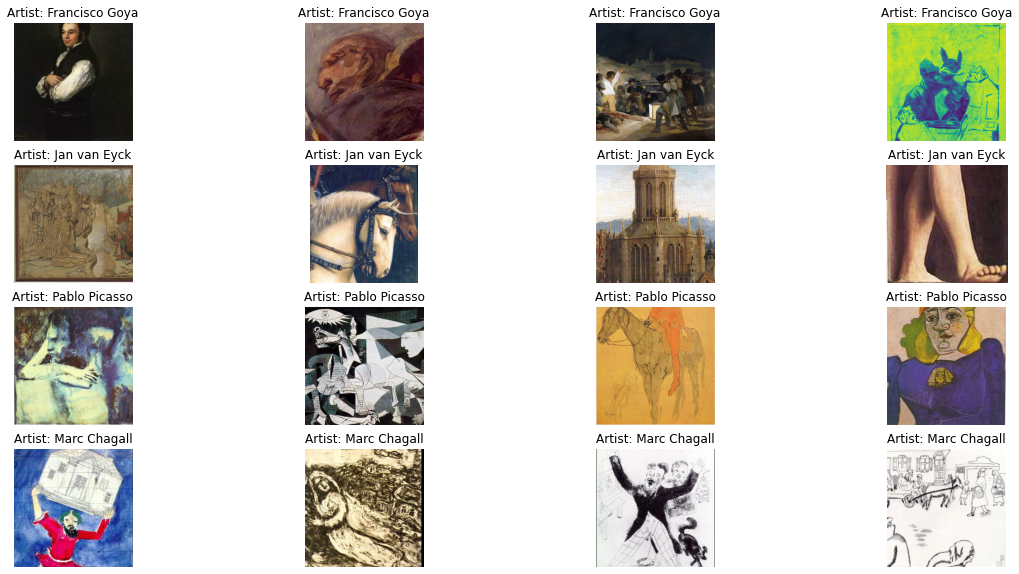

-------------------------
RANDOM PAINTINGS VALIDATE
-------------------------


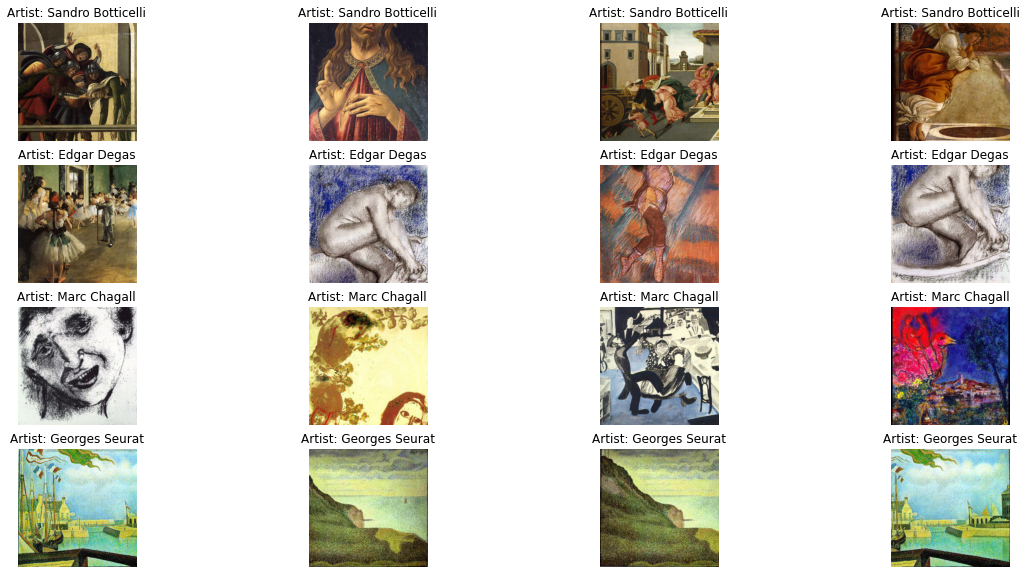

----------------------
RANDOM PAINTINGS TEST
----------------------


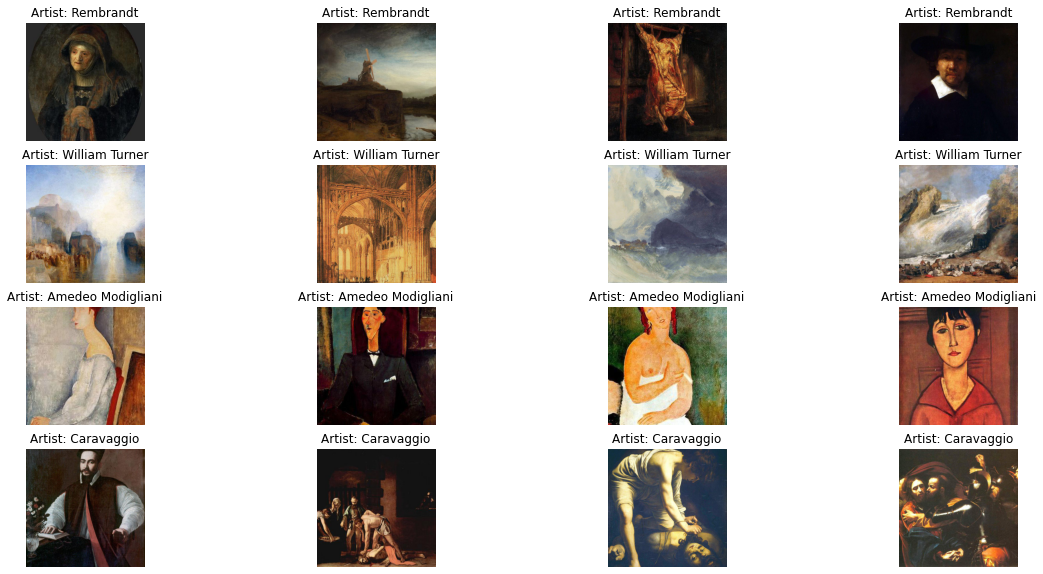

In [13]:
# TRAIN
print("----------------------")
print("RANDOM PAINTINGS TRAIN")
print("----------------------")
show_random_paintings(artist_painting_dict_train)
print("-------------------------")
print("RANDOM PAINTINGS VALIDATE")
print("-------------------------")
show_random_paintings(artist_painting_dict_validate)
print("----------------------")
print("RANDOM PAINTINGS TEST")
print("----------------------")
show_random_paintings(artist_painting_dict_test)

Train hash
4747816857476441714

Train samples: 10331
Inspecting class: label
Number of classes: 50
Max value: ['Vincent_van_Gogh']; 1125
Min value: ['Jackson_Pollock']; 35


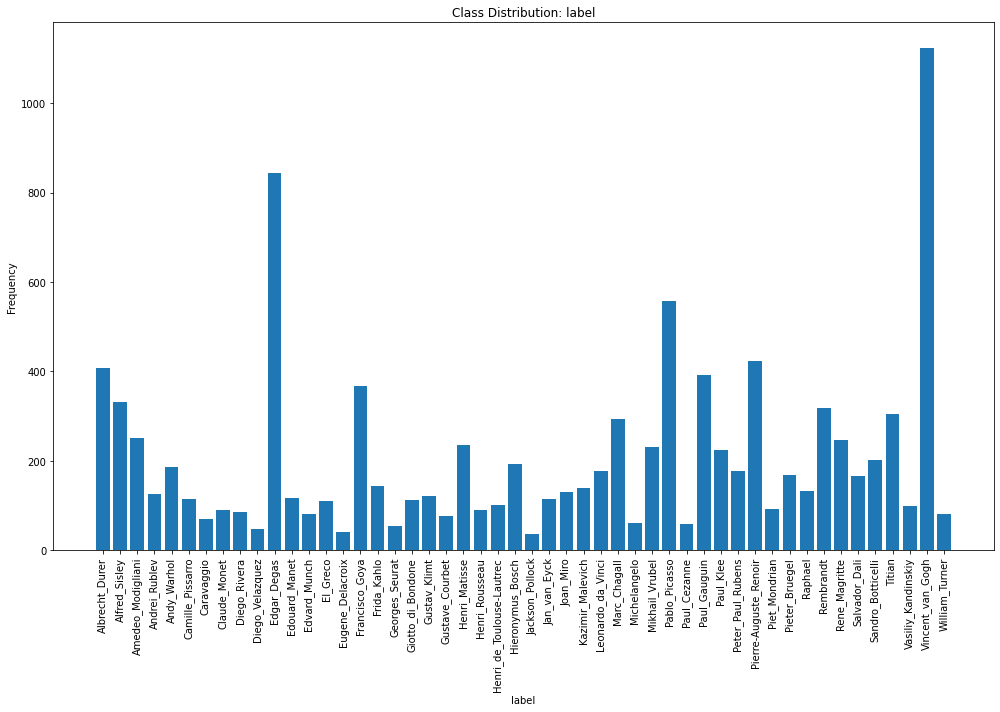

Validate hash
3044357635763318517

Validate samples: 2580
Inspecting class: label
Number of classes: 50
Max value: ['Vincent_van_Gogh']; 281
Min value: ['Jackson_Pollock']; 8


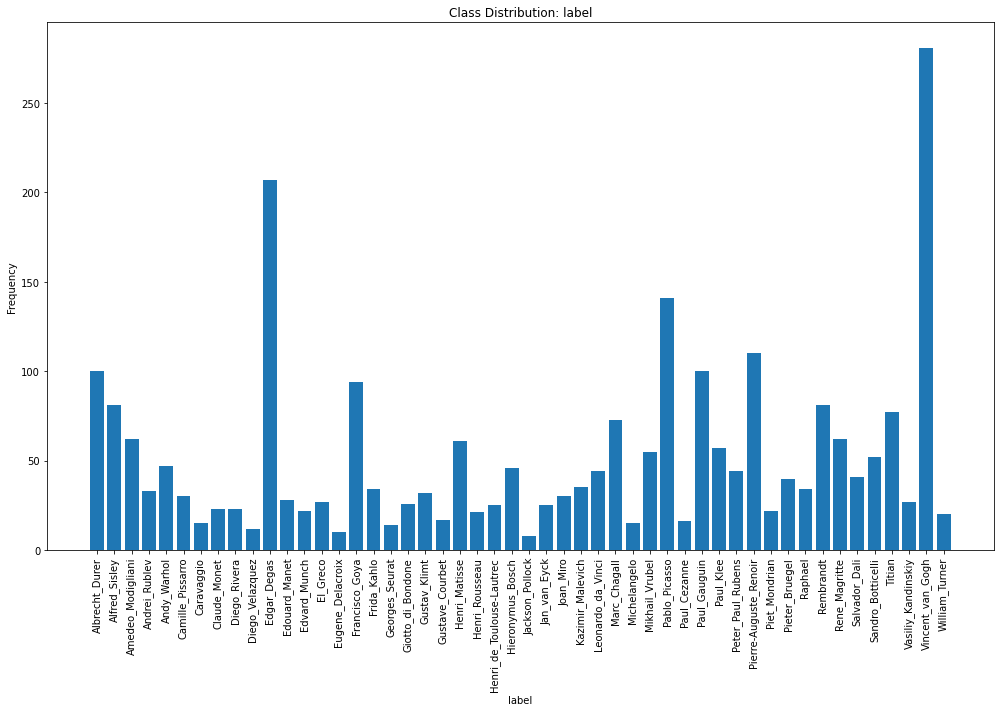


TEST SPLIT
Test samples: 1671
Inspecting class: label
Number of classes: 50
Max value: ['Vincent_van_Gogh']; 175
Min value: ['Jackson_Pollock']; 5


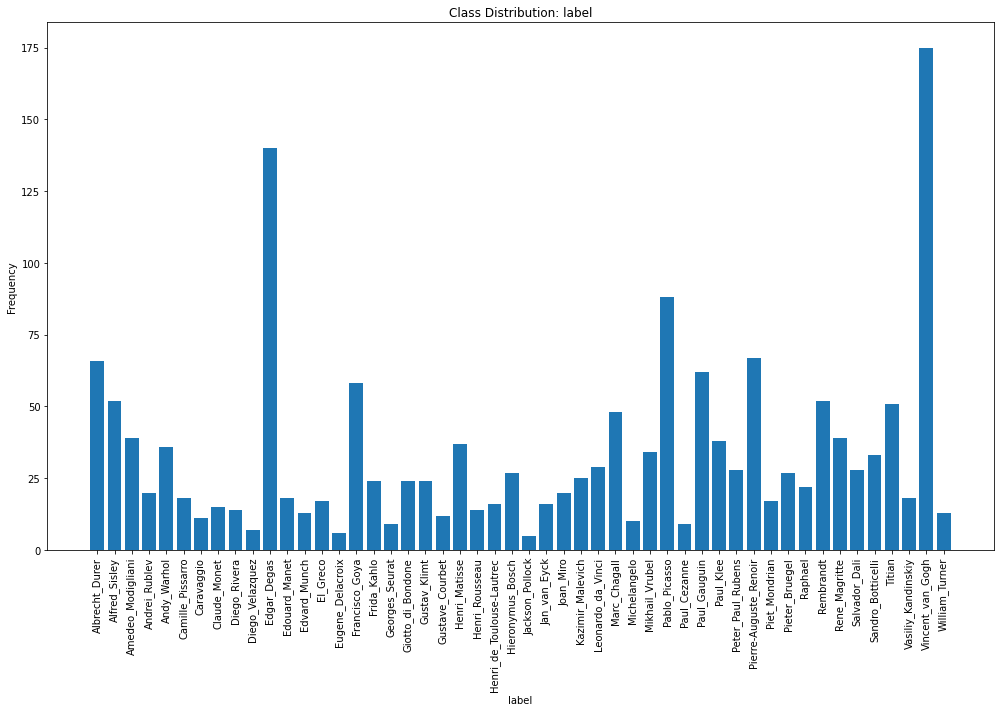

Test hash
-6600253855262263919


Making Train Generator
Found 10331 validated image filenames belonging to 50 classes.

Making Validate Generator
Found 2580 validated image filenames belonging to 50 classes.

Making Test Generator
Found 1671 validated image filenames belonging to 50 classes.
Total number of batches = 80 and 20


In [14]:
from pandas.util import hash_pandas_object

# Now stratified splitting the train and validate set
# X_train, X_validate, y_train, y_validate = train_test_split(
#                                                     df_train_validate['filename'],
#                                                     df_train_validate['label'],
#                                                     test_size=0.2,
#                                                     random_state=seed,
#                                                     stratify= df_train_validate['label']
#                                                     )

# ----- FINAL TRAIN SET ----- #
df_train = pd.DataFrame.from_dict(painting_artist_dict_train, orient= 'index')
df_train.reset_index(level=0, inplace=True)
df_train.columns = ['filename', 'label']
train_hash = hash_pandas_object(df_train).sum()
print("Train hash")
print(train_hash)
print("")

print("Train samples: %d" % df_train.shape[0])
plot_class_distribution(df_train, 'label')


# ----- FINAL VALIDATE SET ----- #
df_validate = pd.DataFrame.from_dict(painting_artist_dict_validate, orient= 'index')
df_validate.reset_index(level=0, inplace=True)
df_validate.columns = ['filename', 'label']
validate_hash = hash_pandas_object(df_validate).sum()
print("Validate hash")
print(validate_hash)
print("")

print("Validate samples: %d" % df_validate.shape[0])
plot_class_distribution(df_validate, 'label')

# ----- FINAL TRAIN SET ----- #
print("")
print("TEST SPLIT")
df_test = pd.DataFrame.from_dict(painting_artist_dict_test, orient= 'index')
df_test.reset_index(level=0, inplace=True)
df_test.columns = ['filename', 'label']

print("Test samples: %d" % df_test.shape[0])
plot_class_distribution(df_test, 'label')
test_hash = hash_pandas_object(df_test).sum()
print("Test hash")
print(test_hash)
print("")


# ----- MAKING GENERATORS FOR TRAINING ----- #
print("")
print("Making Train Generator")
# image data generator where augmentation can be used
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    subset= "training",
    x_col = 'filename',
    y_col = 'label',
    classes=classes,
    target_size=train_input_shape[0:2],
    class_mode = 'categorical',
    shuffle=False,
    batch_size = batch_size
)

print("")
print("Making Validate Generator")
# no augmentation can be used here
validate_datagen = ImageDataGenerator()
valid_generator = validate_datagen.flow_from_dataframe(
    dataframe = df_validate,
    subset= "training",
    x_col = 'filename',
    y_col = 'label',
    target_size=train_input_shape[0:2],
    class_mode = 'categorical',
    classes=classes,
    shuffle=True,
    batch_size = batch_size
)

print("")
print("Making Test Generator")
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    x_col = 'filename',
    y_col = 'label',
    target_size= train_input_shape[0:2],
    class_mode = 'categorical',
    classes=classes,
    shuffle=False
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

### Check images in the generator

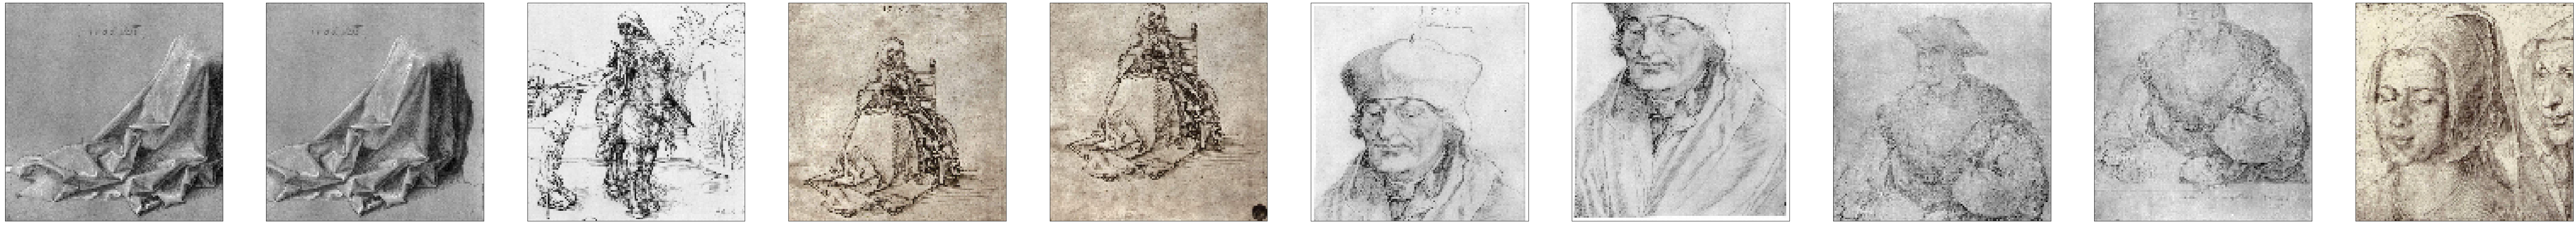

In [17]:
x_batch,y_batch = iter(train_generator)[0]


### PLOT IMAGE WITH PREDICTION
subplot_args = { 'nrows': 1, 'ncols': 10, 'figsize': (100,100),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
fig, ax = plt.subplots(**subplot_args)
for i in range(0,10):
  img = np.expand_dims(x_batch[i], axis=0)
  ax[i].imshow(tf.keras.preprocessing.image.array_to_img(x_batch[i]))
plt.show()


## Training

In [ ]:
class HistoryCheckpoint(History):
  def __init__(self, pickle_path, monitor):
    """
    A custom callback that saves the training history to a pickle file after
    every epoch.
    Arguments:
      pickle_path: the path of where the history should be stored.
      monitor: the value that indicates what the 'best' model is.
    """
    super().__init__()
    self.pickle_path = pickle_path
    self.monitor = monitor
    self.is_resuming = False

  def load_history(self):
    """
    Try to open the history file at the given pickle_path.
    """
    with open(self.pickle_path, "rb") as file:
      self.history = pickle.load(file)
      self.epoch = [i for i in range(len(self.history['loss']))]
      self.is_resuming = True
      

  def on_train_begin(self, logs=None):
    # If not already resuming from a loaded history, then initialize all
    # fields using the code from the History callback.
    if not self.is_resuming:
      super().on_train_begin(logs)

  def on_epoch_end(self, epoch, logs=None):
    # Update the history according to the functionality of History.
    super().on_epoch_end(epoch, logs)

    # Save the history to a pickle file.
    with open(self.pickle_path, "wb") as file:
      pickle.dump(self.history, file)

  def on_train_end(self, logs=None):
    os.remove(self.pickle_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0

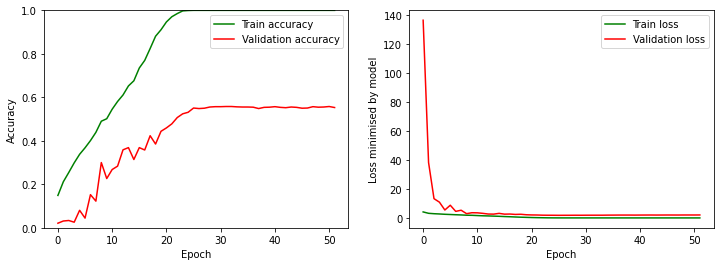

In [ ]:
checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/Final Project/"
best_model_savename = checkpoint_dir+"best_model.h5"
best_model_json_savename = checkpoint_dir+"best_model.json"
monitor = 'val_accuracy'

# CALLBACKS
best_cp_callback = ModelCheckpoint(best_model_savename,
                                   monitor=monitor,
                                   save_weights_only=False,
                                   save_best_only=True,
                                   verbose=1)

backup_callback = BackupAndRestore(checkpoint_dir + "backup/")

stopping_callback = EarlyStopping(monitor=monitor, patience=early_stopping_patience, verbose=1, 
                            mode='auto', restore_best_weights=True)

history_callback = HistoryCheckpoint(checkpoint_dir + "history.pi", 
                                     monitor=monitor)



# CREATE MODEL
# model = example_model()
# model = resnet_model()
model = initial_model()
model_json = model.to_json()
with open(best_model_json_savename, "w") as json_file:
    json_file.write(model_json)
model.summary()

# START TRAINING
try:
  # Try to resume from a history.
  history_callback.load_history()

  # Set the best value from this history in the 'best model' callback.
  if best_cp_callback.monitor_op == np.less:
    best_cp_callback.best = np.min(history_callback.history[monitor])
  if best_cp_callback.monitor_op == np.greater:
    best_cp_callback.best = np.max(history_callback.history[monitor])
  print(f"History with {len(history_callback.epoch)} epochs loaded!")
except OSError:
  print("No history found, starting new logs!")


callbacks = [history_callback, backup_callback, best_cp_callback]
if early_stopping_patience != 0:
  callbacks.append(stopping_callback)



model.fit(train_generator, steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data=valid_generator, validation_steps = STEP_SIZE_VALID,
          epochs=n_epoch,
          shuffle=True,
          verbose=2,
          callbacks=callbacks
          )
history = history_callback

[train_loss, train_accuracy] = model.evaluate(train_generator, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(valid_generator, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))



plot_history(history)

In [ ]:
# Normally, the backup is deleted automatically after all training epochs have ended. 
# Executing this command forces the deletion even if the training is not done yet.
!rm -r "{checkpoint_dir + "backup/"}"
#!rm -r "{checkpoint_dir + "checkpoints/"}"

# Again, the history will be removed after a full training run automatically,
# but you can force the history to be deleted to be sure:
!rm -r "{checkpoint_dir + "history.pi"}"

rm: cannot remove '/content/gdrive/My Drive/Colab Notebooks/DL2021/Final Project/history.pi': No such file or directory


## Analysis
### Loading Model for Analysis (do not execute if not needed)

In [ ]:
from keras.models import model_from_json

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/Final Project/Saved Models/"
load_model_json = checkpoint_dir+"22_04_custom_model.json"
load_model_h5 = checkpoint_dir+"22_04_custom_model.h5"


# load json and create model
json_file = open(load_model_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(load_model_h5)
print("Loaded model from disk")

Loaded model from disk


### Classification Report

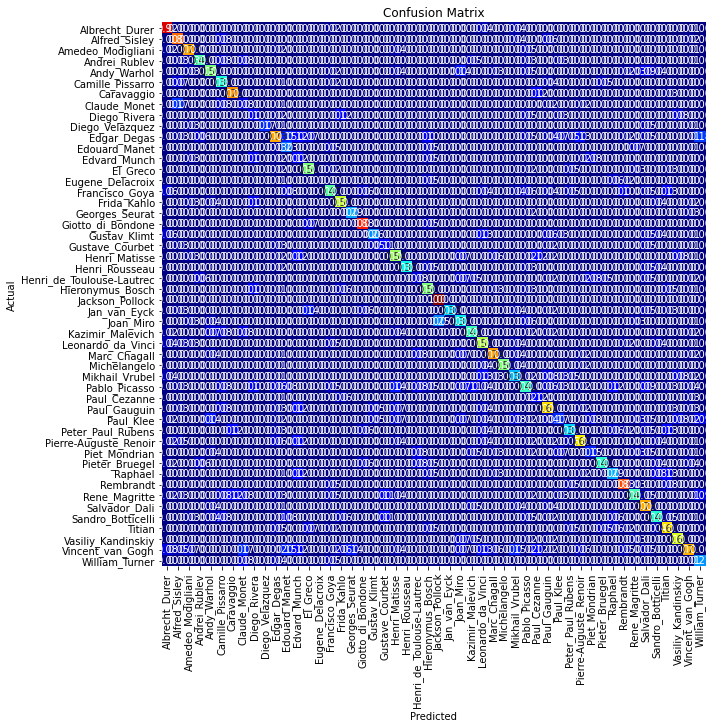

Classification Report:
                           precision    recall  f1-score   support

           Albrecht_Durer       0.70      0.92      0.80        51
            Alfred_Sisley       0.59      0.80      0.68        40
        Amedeo_Modigliani       0.67      0.73      0.70        30
            Andrei_Rublev       0.70      0.44      0.54        16
              Andy_Warhol       0.54      0.50      0.52        28
         Camille_Pissarro       0.38      0.38      0.38        13
               Caravaggio       0.75      0.75      0.75         8
             Claude_Monet       0.14      0.08      0.11        12
             Diego_Rivera       0.20      0.10      0.13        10
          Diego_Velazquez       1.00      0.17      0.29         6
              Edgar_Degas       0.55      0.73      0.63       109
            Edouard_Manet       0.30      0.23      0.26        13
             Edvard_Munch       0.14      0.12      0.13         8
                 El_Greco       0.58  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set Accuracy:   0.56
Test set Loss: 1.8791



In [ ]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = classes

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=classes))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)


opt = tf.keras.optimizers.Adam(learning_rate=lr)  
model.compile(loss='categorical_crossentropy',  
optimizer=opt,  
metrics=['accuracy']) 

[valid_loss, valid_accuracy] = model.evaluate(valid_generator, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(valid_accuracy))
print("Validation set Loss:{:7.4f}\n".format(valid_loss))

### Random Predictions of Validation Set

/content/artists_recognition_dataset/resized/slices/Mikhail_Vrubel_25.jpg
/content/artists_recognition_dataset/resized/slices/Vincent_van_Gogh_576.jpg
/content/artists_recognition_dataset/resized/slices/Vincent_van_Gogh_285.jpg
/content/artists_recognition_dataset/resized/slices/Andy_Warhol_58.jpg
/content/artists_recognition_dataset/resized/slices/Paul_Klee_60.jpg


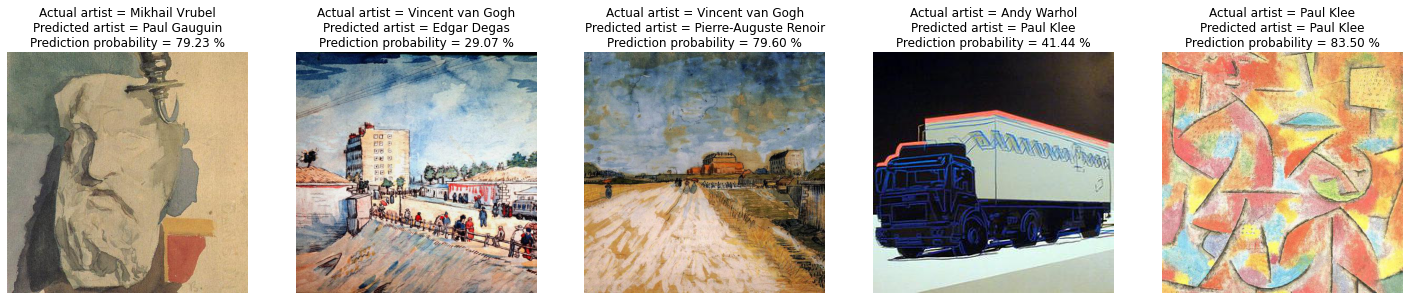

In [ ]:
# Prediction
from keras.preprocessing import *
from PIL import Image


from sklearn.preprocessing import scale
n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):

    row = df_validate.sample()
    random_artist = row.iloc[0][1]
    random_image_file = row.iloc[0][0]
    print(random_image_file)

    test_image = Image.open(random_image_file) 
    test_image = test_image.resize(train_input_shape[0:2])
    test_image = np.expand_dims(test_image, axis=0)

    # TODO this prediction probability is not correct
    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

## Most Confusing

In [ ]:
#Gets pairs of artists that are confused with eachother, along with the number of times this happens
def get_most_confusing(model, valid_generator, STEP_SIZE_VALID):

  y_pred, y_true = [], []
  for i in range(STEP_SIZE_VALID):
      (X,y) = next(valid_generator)
      y_pred.append(model.predict(X))
      y_true.append(y)

  y_pred = [subresult for result in y_pred for subresult in result]
  y_true = [subresult for result in y_true for subresult in result]
  y_true = np.argmax(y_true, axis=1)
  y_true = np.asarray(y_true).ravel()
  y_pred = np.argmax(y_pred, axis=1)
  y_pred = np.asarray(y_pred).ravel()

  conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
  confused_idx = []
  confused_vals = []
  confusing = {}

  for idx in range(conf_matrix.shape[0]):
    row = list(conf_matrix[idx, :])

    indices = []
    values = []
    for j in range(len(row)):
      if(row[j] > 0 and j != idx):
        indices.append(j)
        values.append(row[j])
    confused_idx.append(indices)
    confused_vals.append(values)

  for i in range(len(confused_idx)):
    temp = confused_idx[i]
    for j in range(len(temp)):
      if(i in confused_idx[temp[j]]):
        name1 = tick_labels[i]
        name2 = tick_labels[temp[j]]
        key =  name1 + ' <--> ' + name2
        reverse_key = name2 + ' <--> ' + name1
        if(reverse_key in confusing):
          if(confusing[reverse_key] > confused_vals[i][j]):
            confusing[reverse_key] = confused_vals[i][j]
        else:
          confusing[key] = confused_vals[i][j]
  return confusing

print(get_most_confusing(model, valid_generator, STEP_SIZE_VALID))

In [ ]:
def scatter_scores(model, valid_generator, STEP_SIZE_VALID, threshold=0.25): 

  y_pred, y_true = [], [] 

  for i in range(STEP_SIZE_VALID): 
    (X,y) = next(valid_generator) 
    y_pred.append(model.predict(X)) 
    y_true.append(y) 

  # Create a flat list for y_true and y_pred 
  y_pred = [subresult for result in y_pred for subresult in result] 
  y_true = [subresult for result in y_true for subresult in result] 

  # Update Truth vector based on argmax 
  y_true = np.argmax(y_true, axis=1) 
  y_true = np.asarray(y_true).ravel() 

  # Update Prediction vector based on argmax 
  y_pred = np.argmax(y_pred, axis=1) 
  y_pred = np.asarray(y_pred).ravel() 

  report = classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=classes, output_dict=True) 
  plt.figure(figsize=(10,10)) 
  plt.xlabel('Count') 
  plt.ylabel('F1-score') 
  plt.ylim([-0.05,1.05])

  unique, counts = np.unique(df_validate['label'], return_counts=True) 
  idx = 0 
  for i in range(unique.shape[0]): 
    artist = unique[i] 
    count = counts[i] 
    f1 = report[artist]['f1-score'] 
    plt.scatter(count, f1) 

    if(f1 < threshold): 
      if(f1 > 0): 
        if(idx%2 == 0): 
          plt.text(count * (1.01), f1 * (1.1) , artist, fontsize=8) 
        else: 
          plt.text(count * (1.01), f1 * (0.9) , artist, fontsize=8) 
      else: 
        if(idx%2 == 0): 
          plt.text(count, 0.01*idx , artist, fontsize=8) 
        else: 
          plt.text(count, -0.01*idx , artist, fontsize=8) 
      idx+=1 
  plt.show() 

scatter_scores(model, valid_generator, STEP_SIZE_VALID, threshold=0.3)

### Saliency Maps

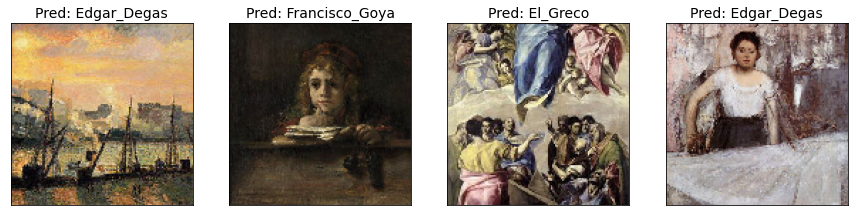

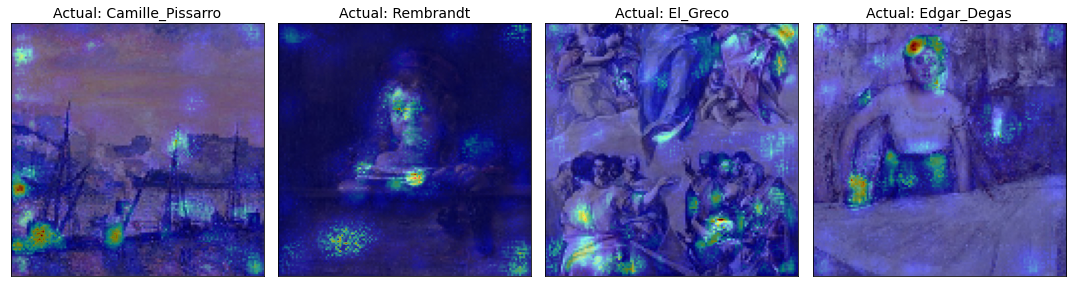

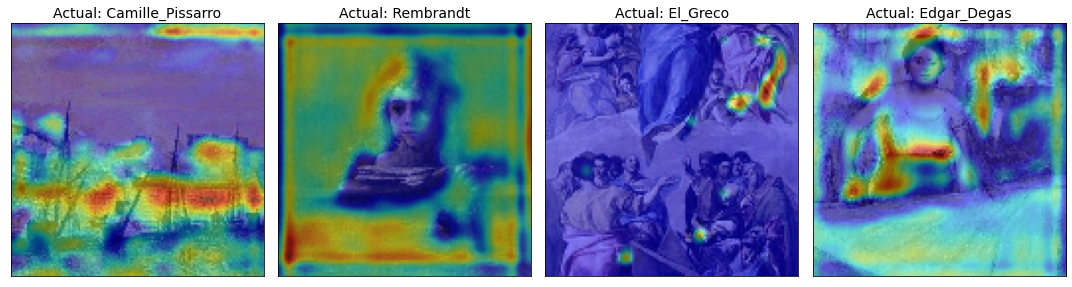

In [ ]:
NB_IMAGES = 4
NB_BATCH = 1

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize


### EXTRACT BATCH FROM GENERATOR
x_batch,y_batch = iter(valid_generator)[NB_BATCH]
def search_label(y_array):
  return classes[np.where(y_array == 1)[0][0]]
def search_index(y_array):
  return np.where(y_array == 1)[0][0]
y_batch_labels = list(map(search_label, y_batch))
y_batch_idxs = list(map(search_index, y_batch))


### PLOT IMAGE WITH PREDICTION
subplot_args = { 'nrows': 1, 'ncols': NB_IMAGES, 'figsize': (15,15),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
fig, ax = plt.subplots(**subplot_args)
for i in range(0,NB_IMAGES):
  img = np.expand_dims(x_batch[i], axis=0)
  prediction = model.predict(img)
  prediction_idx = np.argmax(prediction)
  predicted_class_label = classes[prediction_idx]
  actual_label = y_batch_labels[i]

  ax[i].set_title("Pred: "+ predicted_class_label, fontsize=14)
  ax[i].imshow(tf.keras.preprocessing.image.array_to_img(x_batch[i]))
plt.show()



### SALIENCY MAPS


# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(..., 50)` i.e., (samples, classes).
def loss(output):
    loss_array = []
    for i in range(0,NB_IMAGES):
        loss_array.append(output[i][y_batch_idxs[i]])
    return loss_array

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

# Create Saliency object.
# If `clone` is True(default), the `model` will be cloned,
# so the `model` instance will be NOT modified, but it takes a machine resources.
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=True)


# # Generate saliency map
saliency_map = saliency(loss, x_batch[:NB_IMAGES])
saliency_map = normalize(saliency_map)

# # Render
subplot_args = { 'nrows': 1, 'ncols': NB_IMAGES, 'figsize': (15,15),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(y_batch_labels[:NB_IMAGES]):
    ax[i].set_title("Actual: "+title, fontsize=14)
    ax[i].imshow(tf.keras.preprocessing.image.array_to_img(x_batch[i]))
    ax[i].imshow(saliency_map[i], cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()


### GRADCAM


from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              x_batch[:NB_IMAGES],
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)



subplot_args = { 'nrows': 1, 'ncols': NB_IMAGES, 'figsize': (15, 15),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(y_batch_labels[:NB_IMAGES]):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title("Actual: "+title, fontsize=14)
    ax[i].imshow(tf.keras.preprocessing.image.array_to_img(x_batch[i]))
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()

### Test scores

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=lr)  
model.compile(loss='categorical_crossentropy',  
optimizer=opt,  
metrics=['accuracy']) 

[test_loss, test_accuracy] = model.evaluate(test_generator, verbose=0)
print("Test set Accuracy:{:7.2f}".format(test_accuracy))
print("Test set Loss:{:7.4f}\n".format(test_loss))

Test set Accuracy:   0.57
Test set Loss: 1.7917

